**SECCIÓ 3: Mètodes espectrals**  
**Exemples 3.1-3.4: Equació del calor**

En aquest repositori es presenta la simulació emprada per a l’equació del calor, **Exemples 3.1-3.4**, que correspon a la **Secció 3** del treball.

In [36]:
import numpy as np 
import matplotlib.pyplot as plt 
import numpy.polynomial.chebyshev as np_cheb
from scipy.integrate import solve_ivp
from scipy.linalg import solve_banded
from math import pi
import matplotlib.pylab as pylab
from scipy.special import eval_chebyt
from scipy.linalg import expm
from scipy.interpolate import interp1d

params = {
    'legend.fontsize': 10,
    'legend.loc': 'best',
    'figure.figsize': (14, 5),
    'lines.markerfacecolor': 'none',
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'grid.alpha': 0.6,
    "text.usetex": True,                       
    "font.family": "serif",                    
    "font.serif": ["Computer Modern Roman"],   
    "text.latex.preamble": r"\usepackage{amsmath}" 
}


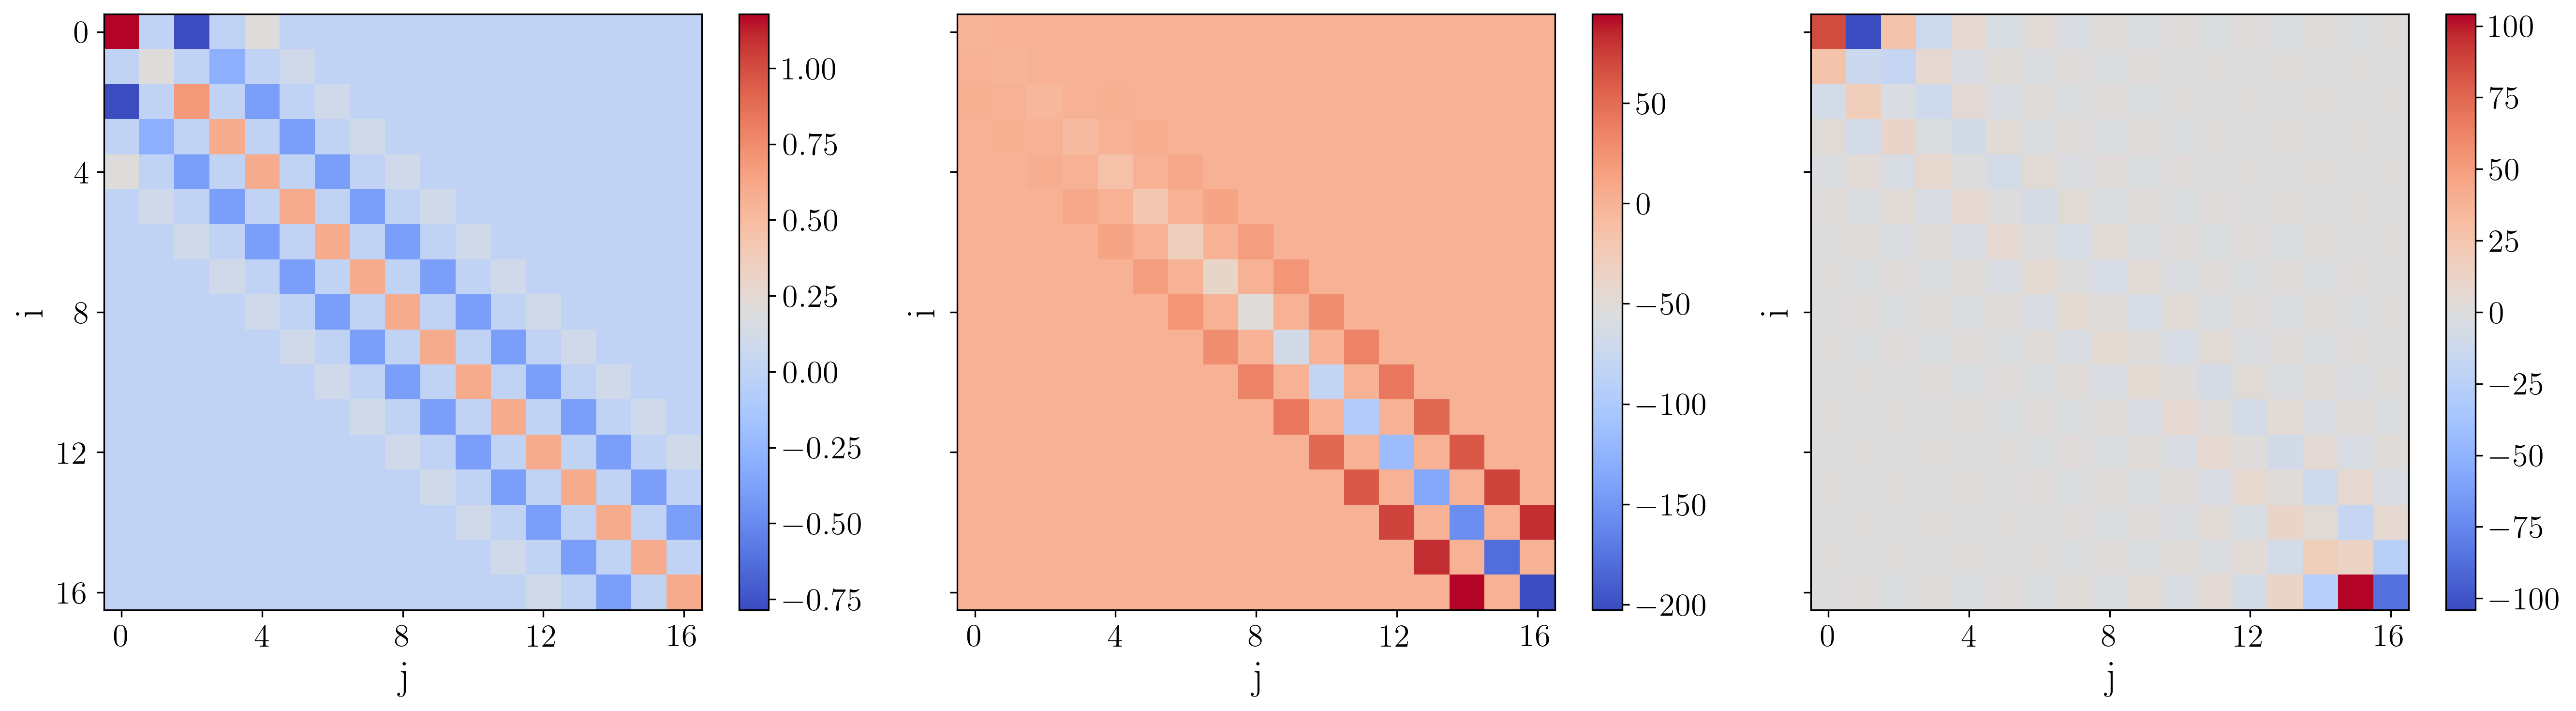

In [24]:
# --------------------------
# Figura 1
#   matrius A i B (Exemples 3.3)
#   matriu de diferenciacio de Txebitxev (Exemple 3.4 - Apendix A.4.2)
# --------------------------

def compute_A(N):
    A = np.zeros((N+1, N+1))
    points, weights = np_cheb.chebgauss(2*N)
    for i in range(N+1):
        for j in range(N+1):
            Ti = np_cheb.Chebyshev.basis(i)
            Tj = np_cheb.Chebyshev.basis(j) 
            A[i, j] = np.sum((1 - points**2) * Ti(points) * (1 - points**2) * Tj(points) * weights)
    return A

def compute_B(N):
    B = np.zeros((N+1, N+1))
    points, weights = np_cheb.chebgauss(2*N)
    for i in range(N+1):
        for j in range(N+1):
            Ti = np_cheb.Chebyshev.basis(i)
            Tj = np_cheb.Chebyshev.basis(j) 
            dTj = Tj.deriv()
            ddTj = dTj.deriv()
            
            B[i, j] = np.sum((1 - points**2) * Ti(points) * (ddTj(points) - 2 * Tj(points) - 4 * points * dTj(points) - points**2 * ddTj(points)) * weights)
    return B

def chebyshev_differentiation_matrix(N):
    x = np.cos(np.pi * np.arange(N + 1) / N)
    D = np.zeros((N + 1, N + 1))

    c = np.ones(N + 1)
    c[0] = 2
    c[-1] = 2
    c *= (-1) ** np.arange(N + 1)  

    for i in range(N + 1):
        for j in range(N + 1):
            if i != j:
                D[i, j] = (c[i] / c[j]) / (x[i] - x[j])
            else:
                if i == 0:
                    D[i, j] = (2 * N**2 + 1) / 6
                elif i == N:
                    D[i, j] = -(2 * N**2 + 1) / 6
                else:
                    D[i, j] = -x[i] / (2 * (1 - x[i]**2))
    return D


# --------------------------
# Dibuix 
# --------------------------
N = 16 #Numero d'harmonics 
D = chebyshev_differentiation_matrix(N)
A = compute_A(N)
B = compute_B(N)

fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey = True)

matrices = [A, B, D]
for ax, mat, title in zip(axs, matrices, titles):
    c = ax.imshow(mat, cmap='coolwarm', aspect='auto')
    fig.colorbar(c, ax=ax)
    #ax.set_title(title)
    ax.set_xlabel('j', fontsize = 20)
    ax.set_ylabel('i', fontsize = 20)
    ax.set_xticks([0, 4, 8, 12, 16])
    ax.set_yticks([0, 4, 8, 12, 16])

plt.tight_layout()
plt.show()

In [25]:
# --------------------------
# Funcions útils pel canvi de base (Consultar: https://kth-nek5000.github.io/kthNekBook/_notebooks/interpolation.html)
# --------------------------

def lagrange_interpolation(x_eval, x_nodes, y_nodes):
    N = len(x_nodes)
    L = np.zeros_like(x_eval)
    for i in range(N):
        xi = x_nodes[i]
        li = np.ones_like(x_eval)
        for j in range(N):
            if i != j:
                li *= (x_eval - x_nodes[j]) / (xi - x_nodes[j])
        L += y_nodes[i] * li
    return L

def modified_cheb_fit(f, N):
    M = 2 * N  
    x = np.cos(np.pi * (np.arange(M + 1)) / M)
    f_vals = f(x)

    V = np.zeros((M + 1, N + 1))
    for k in range(N + 1):
        T_k = eval_chebyt(k, x)
        V[:, k] = (1 - x**2) * T_k

    a, *_ = np.linalg.lstsq(V, f_vals, rcond=None)
    return a, x, f_vals

In [33]:
# --------------------------
# Parameters
# --------------------------
kappa = 0.1 #terme difussiu 
sigma = 0.1 #Condicio inicial (gaussiana amb desv. est. sigma)
T = 0.3 #temps final

# --------------------------
# Solucio exacte (Metode de Fourier-Galerkin amb molts harmònics )
# --------------------------
def sol_exact(N_fourier, sigma, kappa, T, x_interp):
    L = 2
    x = np.linspace(-1, 1, N_fourier, endpoint=False)
    dx = L / N_fourier

    # Condicio inicial
    u0 = np.exp(-x**2 / (2 * sigma**2))

    #Evolucio temporal
    k = np.fft.fftfreq(N_fourier, d=dx) * 2 * np.pi
    u_hat = np.fft.fft(u0)
    u_hat *= np.exp(-kappa * k**2 * T)
    u_exact = np.real(np.fft.ifft(u_hat))

    interpolador = interp1d(x, u_exact, kind='cubic', fill_value="extrapolate")
    u_interp = interpolador(x_interp)

    return u_interp

# -------------------------
# Metode de Fourier-Galerkin
# --------------------------
def Fourier_sol(N_fourier, u_exact): 
    x = np.linspace(-1, 1, len(u_exact))

    u_approx = sol_exact(N_fourier, sigma, kappa, T, x)
    error = np.linalg.norm(u_approx - u_exact) / np.linalg.norm(u_exact)

    return error, u_approx

# --------------------------
# Metode de Txebitxev-Galerkin
# --------------------------
def Chebyshev_sol_Galerkin(N_cheb_Galerkin, u_exact):
    A = compute_A(N_cheb_Galerkin)
    B = kappa * compute_B(N_cheb_Galerkin)
    M = np.linalg.solve(A, B)

    x = np.linspace(-1, 1, len(u_exact))

    u_0 = lambda x: (1 - x**2) * np.exp(-x**2 / (2 * sigma**2))
    a_0, x_nodes, f_vals = modified_cheb_fit(u_0, N_cheb_Galerkin)
    a_t = expm(M * T) @ a_0 #Integracio temporal directa. 

    u_approx = sum(a_t[k] * (1 - x**2) * eval_chebyt(k, x) for k in range(N_cheb_Galerkin + 1))
    error = np.linalg.norm(u_approx - u_exact) / np.linalg.norm(u_exact)

    return error, u_approx

# --------------------------
# Metode de Col.locacio-Txebitxev 
# --------------------------
def Chebyshev_sol_Col(N_cheb, u_exact): 
    dt = 0.001 #Pasa de temps 
    u0, uN = 0, 0 #Condicions de contorn

    x = np.linspace(-1, 1, len(u_exact))
    u0_func = lambda x: (1 - x**2) * np.exp(-x**2 / (2 * sigma**2)) #Condicio inicial 
    
    x_cheb = np.cos(np.pi * np.arange(N_cheb + 1) / N_cheb) #Punts Gauss-Lobatto 
    uk = np.array([u0_func(xi) for xi in x_cheb], dtype=float)

    D = chebyshev_differentiation_matrix(N_cheb)
    D2 = kappa * np.dot(D, D)
    D2r = D2[1:-1, 1:-1]

    #Integracio temporal 
    t_steps = int(T / dt)
    for _ in range(t_steps):
        rhs = uk[1:-1] + dt / 2 * np.dot(D2r, uk[1:-1])
        lhs = np.eye(N_cheb - 1) - dt / 2 * D2r
        uk[1:-1] = solve(lhs, rhs)

    u_interp = lagrange_interpolation(x, x_cheb, uk)

    error = np.linalg.norm(u_interp - u_exact) / np.linalg.norm(u_exact)
    return error, u_interp

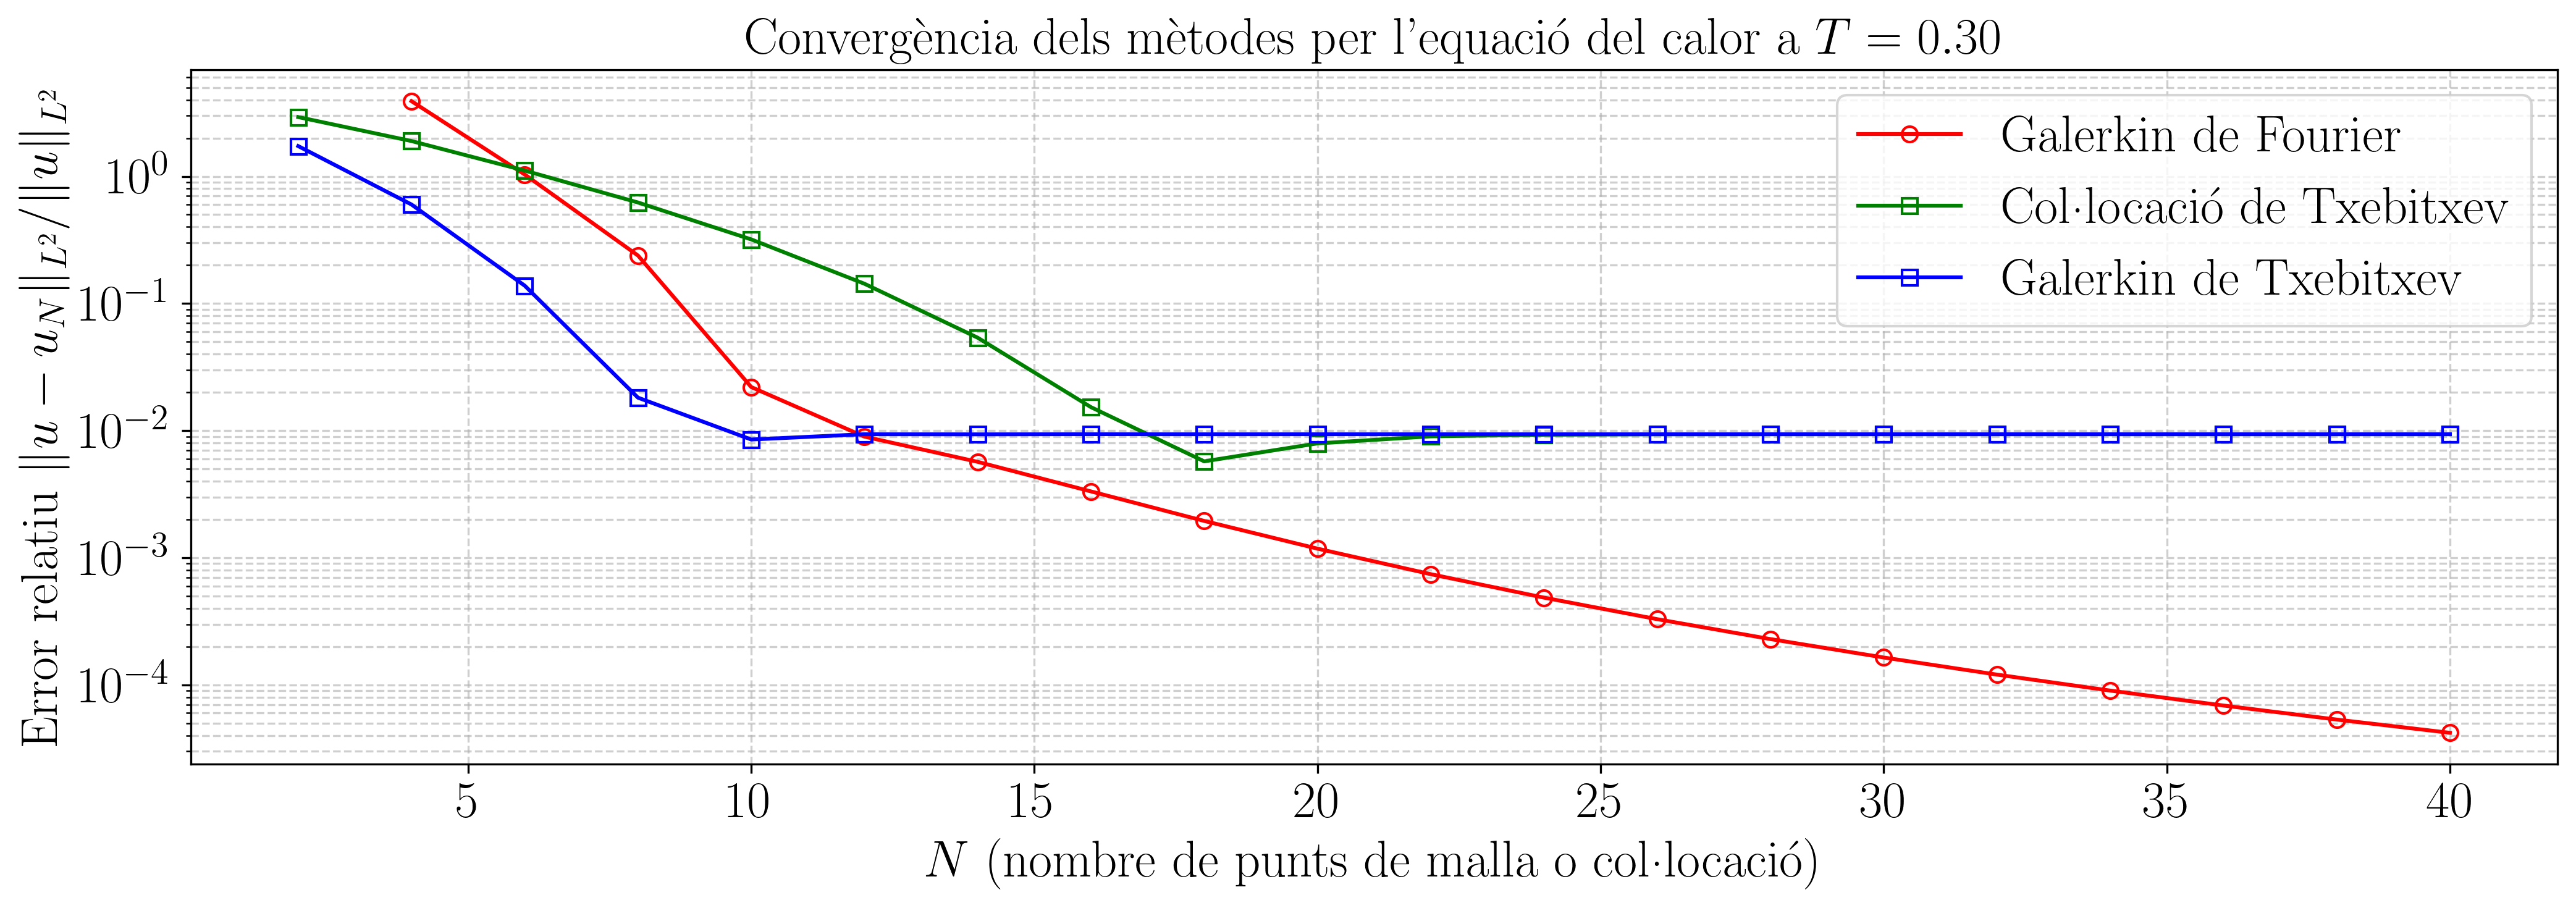

In [41]:
# --------------------------
# Gràfiques d'error relatiu
# --------------------------

N_fourier = 4096 #Solucio exacta prenent 4096 nodes.
Ns_fourier = range(4, 40 + 1, 2) 
Ns_cheb_col = range(2, 40 + 1, 2)
Ns_cheb_galerkin = range(2, 40 + 1, 2)


x = np.linspace(-1, 1, 250)
u_exact = sol_exact(N_fourier, sigma, kappa, T, x)

errors_fourier = [Fourier_sol(N, u_exact)[0] for N in Ns_fourier]
errors_cheb_col = [Chebyshev_sol_Col(N, u_exact)[0] for N in Ns_cheb_col]
errors_cheb_Galerkin = [Chebyshev_sol_Galerkin(N, u_exact)[0] for N in Ns_cheb]

plt.figure(dpi=300)
plt.semilogy(Ns_fourier, errors_fourier, 'o-', label=r'Galerkin de Fourier', color = 'red')
plt.semilogy(Ns_cheb_col, errors_cheb_col, 's-', label=r'Col·locació de Txebitxev', color = 'green')
plt.semilogy(Ns_cheb_galerkin, errors_cheb_Galerkin, 's-', label=r'Galerkin de Txebitxev', color = 'blue')
plt.xlabel(r'$N$ (nombre de punts de malla o col·locació)', fontsize=20)
plt.ylabel(r'Error relatiu $\|u - u_N\|_{L^2} / \|u\|_{L^2}$', fontsize=20)
plt.title(r'Convergència dels mètodes per l’equació del calor a $T = {:.2f}$'.format(T), fontsize=20)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend(fontsize = 20)
plt.tight_layout()
plt.show()